# <center> Deep Learning <br> учим машину распознaвать текст

### <center> Задача - Optical Character Recognition a.k.a OCR
<center> <img src="imgs/ocr_working.gif">

### <center> Распознавание текста можно разделить на 2 этапа: 
####  <center> - Определение местоположение текста (Text Detection)
####  <center> - Распознавание текста (OCR)
<center> <img src="imgs/ocr-types.png">

### <center>  Как было раньше:
<center> <img src="imgs/oldway.png">

# <center> Эра "Глубокого Обучения" поменяло все

### <center> Зоопарк recongition моделей
<center> <img src="imgs/recongition_types.png">

### <center> Convolutional Recurrent Neural Network (CRNN)
<center> <img src="imgs/crnn-archit.png">

# <center> Convolutions - Как они работают? 
<center> <img src="imgs/img_pixels.png">

### <center> Принцип работы сверток
<center> <img src="imgs/3D_Convolution_Animation.gif">

<center> <img src="imgs/kernels.png">

### <center> Свертки способны выучить очень сложные признаки
<center> <img src="imgs/cnn-feaures.png">

# <center> Recurrent Neural Network (RNN)  - Вторая часть уравнения

### <center> Как работает один блок RNN
<img src="imgs/one_block.png">

### <center>  RNN - отлично подходят для работы с sequences
<center> <img src="imgs/rnn-works.png">

### <center> Каждый блок имеет общую матрицу весов $W$
<center> <img src='imgs/several blocks.png'>

## <center> Вернемся к CRNN

### <center> Convolutional Recurrent Neural Network (CRNN)
<center> <img src="imgs/crnn-archit.png">

### <center> Переход от image features к sequences
<center> <img src="imgs/features-seq.png">

In [31]:
import string
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from layers import blockCNN, blockRNN
from utils.utils import strLabelConverter, decode_prediction

In [63]:
class CRNN(nn.Module):
    def __init__(self, hidden_size: int, 
                 vocab_size: int, 
                 bidirectional: bool = True, 
                 dropout: float = 0.5):
        super(CRNN, self).__init__()
        # layers
        resnet = resnet18(pretrained=True)
        modules = list(resnet.children())[:-3]
        self.resnet = nn.Sequential(*modules)
        self.cn6 = blockCNN(256, 256, kernel_size=3, padding=1)
        # RNN + Linear
        self.linear1 = nn.Linear(1024, 256)
        self.gru1 = blockRNN(256, hidden_size, hidden_size, dropout=dropout, 
                             bidirectional=bidirectional)
        self.gru2 = blockRNN(hidden_size, hidden_size, vocab_size, dropout=dropout,
                             bidirectional=bidirectional)
        self.linear2 = nn.Linear(hidden_size * 2, vocab_size)
        
    def forward(self, batch: torch.Tensor):
        batch_size = batch.size(0)
        # convolutions
        batch = self.resnet(batch)
        batch = self.cn6(batch, use_relu=True, use_bn=True)
        # make sequences of image features
        batch = batch.permute(0, 3, 1, 2)
        n_channels = batch.size(1)
        batch = batch.view(batch_size, n_channels, -1)
        batch = self.linear1(batch)
        # rnn layers
        batch = self.gru1(batch, add_output=True)
        batch = self.gru2(batch)
        # output
        batch = self.linear2(batch)
        batch = batch.permute(1, 0, 2)
        return batch

In [64]:
alphabet = string.ascii_lowercase + string.digits #все возможные буквы в капче
label_converter = strLabelConverter(alphabet) #энкодер надписей
print(alphabet)
hidden_size = 256
vocab_size = len(alphabet) + 1 # один дополнительный слот для 'blank' знака
bidirectional = True
PATH = 'models/crnn.pt'

crnn = CRNN(hidden_size=hidden_size, vocab_size=vocab_size, bidirectional=bidirectional)
crnn.load_state_dict(torch.load(PATH))

abcdefghijklmnopqrstuvwxyz0123456789


In [65]:
crnn

CRNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [58]:
SAMPLE_PATH = 'data/sample/2b827.png'
# load image 
img_array = np.asarray(Image.open(SAMPLE_PATH).convert('RGB'))
# convert to tensor
img_tensor = torch.from_numpy(img_array/ 255.)
img_tensor = img_tensor.permute(2, 0, 1).unsqueeze(0).to(torch.float32)

descr_list = ['batch size', 'num of channels', 'height', 'width']
for descr, s in zip(descr_list, img_tensor.size()):
    print('%s : %s' % (descr, s))

batch size : 1
num of channels : 3
height : 50
width : 200


In [60]:
logits = crnn(img_tensor)

descr_list = ['max seq len', 'batch size', 'vocab size']
for descr, s in zip(descr_list, logits.size()):
    print('%s : %s' % (descr, s))

max seq len : 13
batch size : 1
vocab size : 37


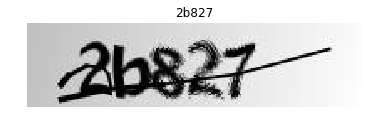

In [62]:
pred = decode_prediction(logits, label_converter)
plt.title(pred)
plt.imshow(img_array)
plt.axis('off');